# Scenario discovery

In this part we use the method PRIM to find scenarios, which are likely to be the worst for our actor. Since we have to deal with two locations, we sometimes do the analysis twice.  
The scenario's are ran on the base case, so that is without any policy. The dataset contains 50.000 scenarios, with the following outcome variables for both A.1 and A.2:
- External Costs
- RfR Costs
- Expected Number of Deaths
- Expected Annual Damage

In [35]:
# Import the libaries
from ema_workbench import load_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from ema_workbench.analysis import prim
import numpy as np
from ema_workbench.util import ema_logging
from ema_workbench.analysis import pairs_plotting, prim
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)
from sklearn.metrics import pairwise_distances

In [36]:
# Defining the filename of the base case. The file is saved in the same directory as the notebook.
input_filename = 'results/base_case'

# Loading the results
results = load_results(input_filename + '.tar.gz')

In [37]:
# Splitting the results into experiments and outcomes
experiments, outcomes = results

# Printing the shape of the experiments
print('shape =', experiments.shape)

# Display the head of the experiments
display(experiments.head())

shape = (50000, 53)


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,...,0,0,0,0,0,0,0,0,No Policy,dikesnet
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,...,0,0,0,0,0,0,0,1,No Policy,dikesnet
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,...,0,0,0,0,0,0,0,2,No Policy,dikesnet
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,...,0,0,0,0,0,0,0,3,No Policy,dikesnet
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,...,0,0,0,0,0,0,0,4,No Policy,dikesnet


In [38]:
# Make a dataframe with the outcomes
df_outcomes = pd.DataFrame(outcomes)
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


To find the worst-case scenarios for which we will optimise policy levers later on, we must first determine for which outcomes of interest these scenarios should be considered worst-case. We consider the following four outcomes:
- A.1_Expected Annual Damage
- A.2_Expected Annual Damage
- A.1_Expected Number of Deaths
- A.2_Expected Number of Deaths

Given the fact that we value each of these outcomes equally, we will add another column to the dataframe for which we will conduct the PRIM analysis. This column will contain the normalised and then aggregated values for the four outcomes mentioned above.

In [39]:
df_outcomes[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']].head(3)


,A.1_Expected Annual Damage,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Expected Number of Deaths
0,0.000000e+00,0.000000,1.285213e+08,0.102270
1,2.057940e+09,1.515402,0.000000e+00,0.000000
2,2.122853e+09,1.466953,9.001870e+07,0.081071


In [40]:
# Set up the scaler to normalise the results
scaler = MinMaxScaler()
normalized_ooi = scaler.fit_transform(df_outcomes[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
composite_ooi = normalized_ooi.sum(axis=1)

# Add the composite ooi to the dataframe
df_outcomes['composite_ooi'] = composite_ooi 

In [41]:
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08,0.262477
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00,1.619012
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07,1.805803
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00,1.652135
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07,0.242187
...,...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07,0.114171
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07,0.128510
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07,0.184347
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00,1.634482


In [45]:
# Create a dataframe with only the uncertainties per scenario

experiments_sliced = experiments.iloc[:,:19]
experiments_sliced

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,335.202711,10.0,0.197244,44.934875,1.5,0.928058,1.5,1.5,3.5
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,274.533484,1.0,0.860717,270.590253,1.0,0.058684,1.5,4.5,4.5
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,152.659419,1.0,0.867790,72.352163,10.0,0.029257,2.5,3.5,2.5
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,34.673513,1.5,0.081300,118.053353,1.0,0.285650,2.5,4.5,2.5
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,288.279890,1.0,0.527409,167.064316,1.0,0.648632,3.5,2.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,62,321.616643,1.5,0.724065,71.881936,10.0,0.690810,348.476106,1.5,0.564494,73.173805,1.5,0.792240,250.531944,10.0,0.788202,4.5,1.5,2.5
49996,36,314.197104,1.5,0.790554,78.448640,1.0,0.535387,190.467088,1.5,0.478701,88.545218,1.0,0.321918,215.959007,1.0,0.324620,1.5,2.5,3.5
49997,30,113.594422,1.0,0.840008,175.576458,1.0,0.509296,299.492845,1.0,0.710544,235.318213,1.0,0.870422,307.847717,10.0,0.862621,2.5,2.5,1.5
49998,55,334.081152,1.0,0.318638,298.865589,1.5,0.614740,144.360129,10.0,0.886877,67.236182,1.5,0.814070,190.160572,1.0,0.609990,1.5,4.5,4.5


To be able to eventually find policies that not only work in favourable scenarios, but also in less favourable scenarios we have to define an uncertainty subspace which we can later use to find optimal and robust policies. To do this, we select the 25% worst scenarios based on the composite ooi score. We can then use PRIM to find limits for the uncertainty values in which as many of the 25% worst scenarios fall, and as little 75% best scenarios fall.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold 0.50:
Threshold 0.55:
Threshold 0.60:
Threshold 0.65:
Threshold 0.70:
Threshold 0.75:
Threshold 0.80:
Threshold 0.85:
Threshold 0.90:


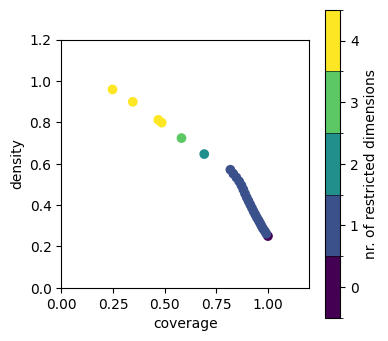

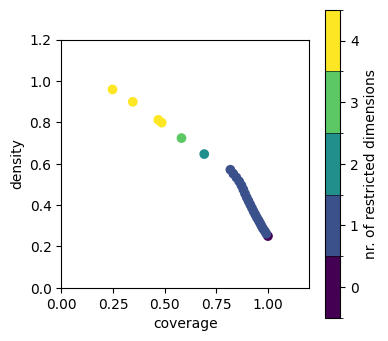

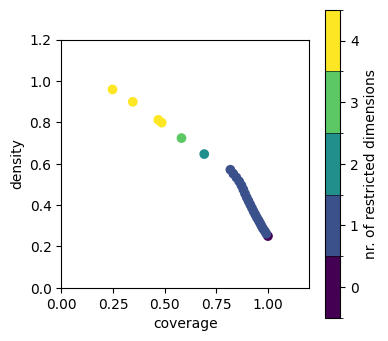

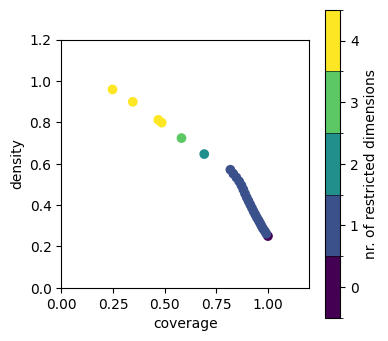

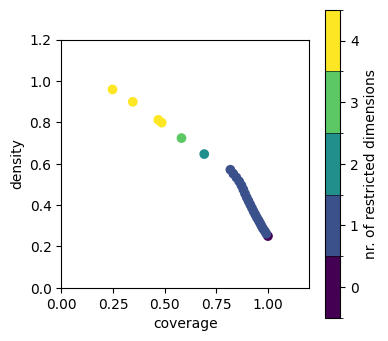

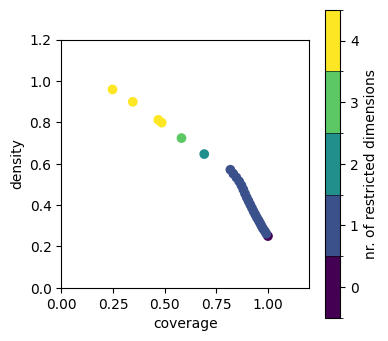

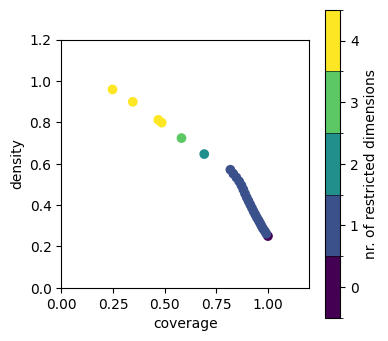

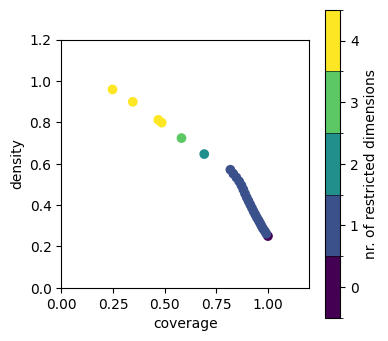

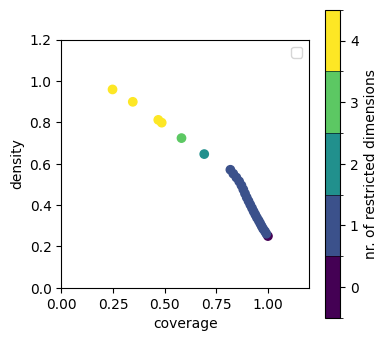

In [46]:
# To find the worst case scenarios, we will consider the worst 25% of the scenarios based on the composite ooi
percentile_composite_ooi = np.percentile(df_outcomes["composite_ooi"], 75)

# Bool the values if they are larger than the threshold
selval = pd.DataFrame()
selval = df_outcomes["composite_ooi"] > percentile_composite_ooi

# To find the most appliclable threshold for the PRIM algorithm (note that this is a different threshold than the composite_ooi threshold), 
# we will plot the trade-offs for different thresholds
# Create a list to store results
boxes = []
thresholds = np.arange(0.5, 0.95, 0.05)

# Run the PRIM algorithm for different thresholds
for threshold in thresholds:
    prim_alg = prim.Prim(experiments_sliced, selval, threshold=threshold, peel_alpha=0.05)
    box = prim_alg.find_box()
    boxes.append((threshold, box))

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (4, 4)

# Plot trade-offs for different thresholds
for threshold, box in boxes:
    print(f'Threshold {threshold:.2f}:')
    box.show_tradeoff()

plt.legend()
plt.show()


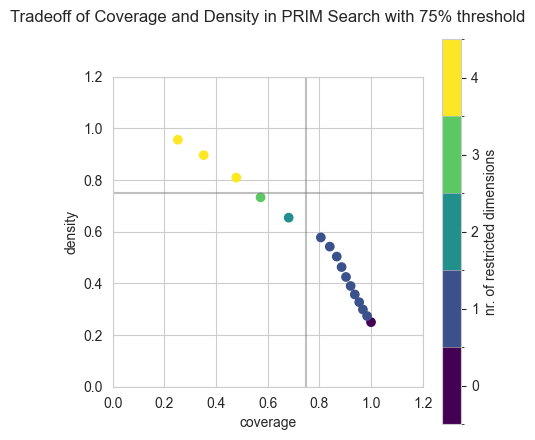

In [49]:
# For a reason we have to admit are unsure of, we pick a threshold of 0.9, as the graphs above indicate that it does not seem to affect to boxes PRIM finds
prim_alg = prim.Prim(experiments_sliced, selval, threshold=0.9, peel_alpha=0.1)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
# We draw lines at 0.75 to more easily see if we can find a box which exceeds a coverage and density of 0.75
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 75% threshold', y=1.15)

plt.savefig("images/PRIM_tradeoff_scenarios")
plt.show()

In [50]:
box1.peeling_trajectory

,coverage,density,id,k,mass,mean,n,res_dim
0,1.00000,0.250000,0,12500,1.00000,0.250000,50000,0
1,0.98480,0.273556,1,12310,0.90000,0.273556,45000,1
2,0.96864,0.298963,2,12108,0.81000,0.298963,40500,1
3,0.95432,0.327270,3,11929,0.72900,0.327270,36450,1
4,0.93720,0.357110,4,11715,0.65610,0.357110,32805,1
5,0.92104,0.389954,5,11513,0.59048,0.389954,29524,1
6,0.90312,0.424862,6,11289,0.53142,0.424862,26571,1
7,0.88608,0.463179,7,11076,0.47826,0.463179,23913,1
8,0.86736,0.503787,8,10842,0.43042,0.503787,21521,1
9,0.84040,0.542390,9,10505,0.38736,0.542390,19368,1


Unfortunately PRIM was unable to find a box exceeding the 75% for both density and coverage. Both metrics are important for our analysis. Coverage is vital as it ensures we capture a large array of concerning scenarios while density is critical because it helps us maintain a targeted approach and prevent the inclusion of too many irrelevant scenarios. Therefore we want a box that is decent for both measures. From the table above, we thus opt to choose box 11 for further analysis.

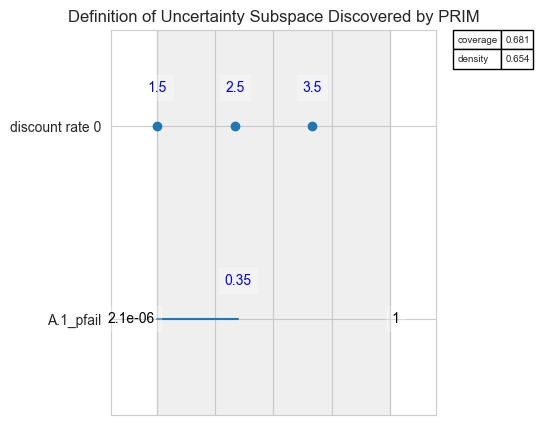

In [52]:
# Further inspecting box 11 to see which dimensions are being restricted
box1.select(11)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
plt.savefig('images/scenario_discovery__prim_boundary.png')
plt.show()

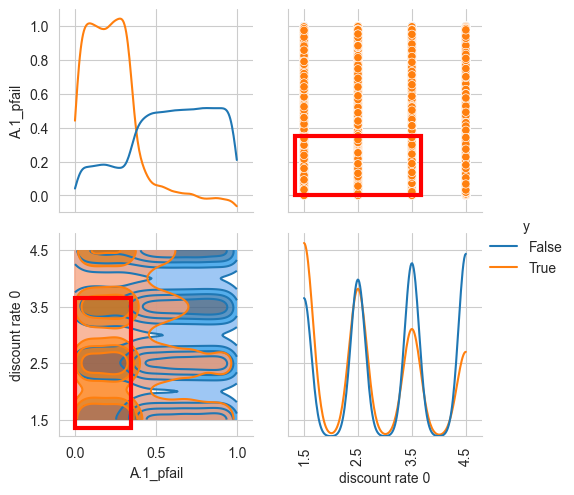

In [65]:
box1.show_pairs_scatter()
plt.savefig('images/prim_pairplot.png')
plt.show()

In [54]:
# Set the limits based on the PRIM box
limits = box1.box_lims[11]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.004597,"{1.5, 10.0, 1.0}",0.000002,30.000705,"{1.5, 10.0, 1.0}",6.540993e-07,30.005824,"{1.0, 10.0, 1.5}",5.224624e-07,30.005383,"{1.0, 10.0, 1.5}",0.000002,30.003400,"{1.5, 10.0, 1.0}",0.000011,"{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.999846,"{1.5, 10.0, 1.0}",0.348623,349.999139,"{1.5, 10.0, 1.0}",9.999961e-01,349.995529,"{1.0, 10.0, 1.5}",9.999872e-01,349.995618,"{1.0, 10.0, 1.5}",1.000000,349.994093,"{1.5, 10.0, 1.0}",0.999998,"{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [55]:
# Setup a dataframe which we can later use to filter the experiments based on the PRIM box limits
combined_df = experiments.copy()
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.merge(df_outcomes[['composite_ooi']], how = 'left', left_index = True, right_index = True)
combined_df['In box limits'] = True

In [56]:

# Create a mask initialized to True
mask = np.ones(len(combined_df), dtype=bool)

# Iterate over the constraints and update the mask
for unc in limits:
    if isinstance(limits.loc[0, unc], set):
        mask &= combined_df[unc].isin(limits.loc[0, unc])
    else:
        mask &= (combined_df[unc] >= limits.loc[0, unc]) & (combined_df[unc] <= limits.loc[1, unc])

# Update the 'In box limits' column based on the mask
combined_df['In box limits'] = mask

In [57]:
# Use new column to filter the rows, then drop this column
combined_df = combined_df[combined_df['In box limits']]
combined_df = combined_df.drop(['In box limits'], axis=1)
print(f'{combined_df.shape[0]} fall within the PRIM box limits')

13013 fall within the PRIM box limits


We started with 50000 scenarios and are now down to 13000. Thse 13000 scenarios all conform to filter we applied to look for the 25% worst scenarios based on the composite_ooi score, however this is still way too much to optimise our policies for. Therefore we will have to filter down further.

In [58]:
# Sort the dataframe by the composite outcome of interest from worst to best
combined_df_sorted = combined_df.sort_values(by='composite_ooi', ascending=False)


In [59]:
# Create a scenario dataframe with the scenarios that fall within the PRIM box limits
experiments_sliced_columns = list(experiments_sliced.columns)
experiments_sliced_columns.append('composite_ooi')
selected_scenarios = combined_df[experiments_sliced_columns]

In [60]:
combined_df_sorted

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
5666,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,...,0,0,0,0,0,0,5666,No Policy,dikesnet,3.851408
37006,112,45.942740,10.0,0.048710,140.411132,1.0,0.024664,82.938927,1.5,0.397429,...,0,0,0,0,0,0,37006,No Policy,dikesnet,3.842766
10872,124,40.037075,1.5,0.142803,341.756695,1.5,0.036182,77.097873,1.5,0.527626,...,0,0,0,0,0,0,10872,No Policy,dikesnet,3.806186
23514,8,71.302063,1.0,0.046825,345.456662,1.0,0.011393,30.957752,1.5,0.700170,...,0,0,0,0,0,0,23514,No Policy,dikesnet,3.743752
456,123,43.660903,10.0,0.199587,181.602356,1.0,0.058039,222.809776,1.5,0.212183,...,0,0,0,0,0,0,456,No Policy,dikesnet,3.716054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7221,94,331.168259,1.5,0.348061,289.915138,1.5,0.735999,188.403412,10.0,0.225255,...,0,0,0,0,0,0,7221,No Policy,dikesnet,1.223055
29071,9,304.130009,10.0,0.346508,183.835119,1.0,0.674772,122.234986,10.0,0.174207,...,0,0,0,0,0,0,29071,No Policy,dikesnet,1.200517
3619,51,82.911645,1.0,0.345628,305.490519,10.0,0.946479,135.541766,10.0,0.504624,...,0,0,0,0,0,0,3619,No Policy,dikesnet,1.198221
8470,51,248.465616,10.0,0.341540,340.138214,10.0,0.313503,81.810139,1.0,0.344787,...,0,0,0,0,0,0,8470,No Policy,dikesnet,1.139769


In [61]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,composite_ooi
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,274.533484,1.0,0.860717,270.590253,1.0,0.058684,1.5,4.5,4.5,1.619012
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,34.673513,1.5,0.081300,118.053353,1.0,0.285650,2.5,4.5,2.5,1.652135
11,57,86.867596,1.5,0.289135,36.165954,10.0,0.784174,56.619470,1.0,0.017841,319.157517,1.0,0.079291,338.329807,1.0,0.584245,1.5,2.5,4.5,1.708537
12,98,40.518658,10.0,0.048493,215.015110,10.0,0.251750,43.043888,10.0,0.950841,178.101227,1.0,0.518300,71.103245,10.0,0.311620,1.5,1.5,3.5,2.260277
17,110,167.602098,10.0,0.297072,137.023696,1.5,0.796270,203.710781,10.0,0.303677,49.825993,1.5,0.515387,85.311863,10.0,0.313269,2.5,3.5,4.5,1.623017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49971,36,134.551195,10.0,0.333751,315.457527,10.0,0.545837,225.492468,10.0,0.245662,272.549063,1.0,0.586350,84.241383,10.0,0.399203,3.5,2.5,2.5,1.662923
49979,85,98.654095,1.5,0.250192,309.389771,1.5,0.587045,172.614260,1.5,0.773476,272.567996,1.5,0.467034,286.772726,1.5,0.760244,2.5,2.5,1.5,1.797761
49987,5,183.911294,10.0,0.200902,121.726054,1.5,0.123799,252.289825,10.0,0.502917,184.640638,1.0,0.930993,326.141996,1.0,0.326025,1.5,2.5,3.5,1.856778
49989,83,129.526500,10.0,0.227638,47.586295,1.5,0.533192,155.004261,1.5,0.181730,65.546542,1.5,0.632453,208.528796,1.0,0.358638,3.5,4.5,1.5,1.691582


To further filter down our 13000 scenarios, we will look at diversity. Eventually we want to aim for a set of 5 scenarios which we'll use for our policy optimisation. Since this is a small number, we want these scenarios to ideally be very diverse. Therefore we continue by calculating scenario diversity by looking at the pairwise distances between each scenario. However, before we do that we randomly sample 100 scenarios from the set of 13000 to reduce the computational burden when calculating the diversity.

In [62]:
# Randomly sample approximately 100 scenarios to reduce the computational burden
sampled_df = selected_scenarios.sample(n=100, random_state=42)

# Normalize the data to ensure fair distance calculations
scaler = StandardScaler()
sampled_df_scaled = scaler.fit_transform(sampled_df)

# Calculate pairwise distances between all sampled scenarios
distance_matrix = pairwise_distances(sampled_df_scaled, metric='euclidean')

# Function to select the most diverse scenarios
def select_diverse_scenarios(distance_matrix, n_select=4):
    # Start with the first scenario
    selected_indices = [0]
    while len(selected_indices) < n_select:
        # Calculate the sum of distances from the already selected scenarios
        dist_sum = np.sum(distance_matrix[selected_indices], axis=0)
        # Select the scenario that maximizes the minimum distance to the already selected scenarios
        next_index = np.argmax(dist_sum)
        selected_indices.append(next_index)
    return selected_indices

# Get indices of the 4 most diverse scenarios
diverse_indices = select_diverse_scenarios(distance_matrix, n_select=4)

# Retrieve the 4 most diverse scenarios from the sampled dataframe
diverse_scenarios = sampled_df.iloc[diverse_indices]

# Print the diverse scenarios
diverse_scenarios


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,composite_ooi
17872,35,186.293269,10.0,0.343812,77.401051,1.0,0.658147,264.897385,10.0,0.541336,223.484894,1.0,0.539570,98.099726,1.0,0.387690,1.5,1.5,4.5,1.827049
11066,123,108.477854,10.0,0.203210,283.478318,1.5,0.432853,222.229473,1.5,0.140830,40.489532,10.0,0.969984,315.559704,10.0,0.745238,3.5,3.5,1.5,1.794227
18563,104,313.352612,1.0,0.335359,83.602832,1.5,0.048482,331.280944,10.0,0.942171,116.239569,1.0,0.444281,207.833347,10.0,0.958399,1.5,4.5,4.5,3.128368
32143,126,340.835544,1.0,0.049016,113.855005,10.0,0.757939,332.888162,1.0,0.130000,131.107110,1.5,0.075126,81.769375,1.0,0.532889,3.5,1.5,4.5,1.693180


Next to selecting the four most diverse scenarios from the sampled subset, we also include the scenario with the highest composite_ooi score as this indicates the absolute worst case scenario which we deem to be very interesting to include as well.

In [63]:
# Select the four most diverse scenarios and the scenario with the highest composite outcome of interest as scenarios to be further analyzed and append the
# worst case (highest composite_ooi score) scenario to the list
selected_indices = diverse_scenarios.index.tolist()
selected_indices.append(combined_df_sorted.index[0])
print(selected_indices)


[17872, 11066, 18563, 32143, 5666]


In [64]:
# Drop the composite ooi column as its not needed anymore and save the selected scenarios to a csv file
selected_scenarios.drop('composite_ooi', axis=1, inplace=True)
selected_scenarios.loc[selected_indices].to_csv('results/selected_scenarios.csv')

/var/folders/mz/j0q1_7_x2f59p13bv_c81xhc0000gn/T/ipykernel_22567/1422912885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_scenarios.drop('composite_ooi', axis=1, inplace=True)
